## 2022 EY Challenge - Sentinel-2 Mosaics

This notebook can be used to create a Sentinel-2 cloud-filtered median mosaic for any time period and location. A median mosaic is quite common and reflects the "median" value of cloud-free pixels for all spectral bands in the time series. The mosaic can be output as a GeoTIFF product for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
import xrspatial.multispectral as ms

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.
<br>We will use the year 2020 as a representative dataset for the region. The query searches for "clear" scenes with cloud cover <20%.
<br>The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [3]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2020-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 20}},
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 61


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (Red, Green, Blue, NIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. This resolution can be easily changed below (e.g. 100 meters) to reduce the data volume of the final GeoTIFF output. This change may be neccesary when considering larger analysis regions. Also, we have selected a resampling method of "average" that will find the mean value of each band to create new pixels. This is only needed when the resolution is changed from 10-meters to larger values (e.g. 100 meters). 

In [4]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [5]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [6]:
data = (
    stackstac.stack(
        signed_items,
        epsg=4326, # Use common Lat-Lon coordinates
        resolution=scale, # Use degrees for crs=4326
        bounds_latlon = bbox,
#        resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
        assets=["B04", "B03", "B02", "B08"],  # Red, Green, Blue, NIR
        chunksize=4096,  
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [7]:
data = data.persist()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<20% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. To get a better solution, we should remove all cloud pixels to compute the median, but for now, we will avoid that additional step.

In [8]:
median = data.median(dim="time").compute()

To visualize the data, we'll use xarray-spatial's `true_color` and `ndvi` functions to display the results. The RGB image is what we would see with our eye if looking from space at the land. 

In [9]:
image = ms.true_color(median.sel(band="red"), median.sel(band="green"), median.sel(band="blue"))

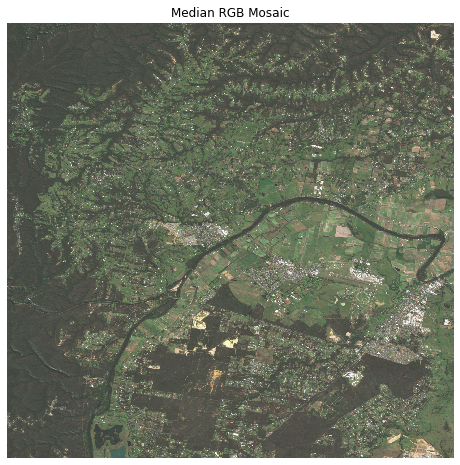

In [10]:
image.plot.imshow(figsize=(8,8))
plt.title("Median RGB Mosaic")
plt.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [11]:
ndvi_median = ms.ndvi(median.sel(band="nir"), median.sel(band="red"))

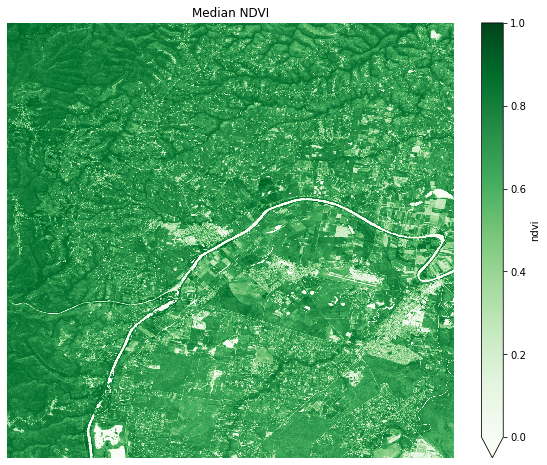

In [12]:
ndvi_median.plot.imshow(cmap="Greens", vmin=0.0, vmax=1.0, figsize=(10,8))
plt.title("Median NDVI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [13]:
filename = "S2_mosaic_sample2.tiff"

In [14]:
# This will report the pixel dimensions of our mosaic file. Recall that pixel resolution will impact the dimensions.
median.sel(band="red").shape

(2339, 2339)

In [15]:
# Set the dimensions of file in pixels
height = median.sel(band="red").shape[0]
width = median.sel(band="red").shape[1]

In [16]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(min_lon,min_lat,max_lon,max_lat,width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [17]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(median.sel(band="red"),1)
    dst.write(median.sel(band="green"),2)
    dst.write(median.sel(band="blue"),3) 
    dst.write(median.sel(band="nir"),4)
    dst.close()

In [18]:
# Show the location and size of the new output file
!ls *.tiff -lah

-rw-rw-r-- 1 jovyan users 122M Jan 19 17:49 DEM_sample.tiff
-rw-r--r-- 1 jovyan users 5.2M Jan 21 18:25 DEM_sample8.tiff
-rw-rw-r-- 1 jovyan users 273K Jan  7 17:21 Land_Cover_sample.tiff
-rw-r--r-- 1 jovyan users 273K Jan 21 18:30 Land_Cover_sample2.tiff
-rw-rw-r-- 1 jovyan users  49M Jan  5 20:26 S2_mosaic_sample.tiff
-rw-r--r-- 1 jovyan users  49M Jan 21 18:40 S2_mosaic_sample2.tiff
-rw-rw-r-- 1 jovyan users  305 Jan  6 01:03 Weather_sample.tiff


### How will the participants use this data?
The GeoTIFF file will contain the Lat-Lon coordinates of each pixel and will also contain the mean band values (Red, Green, Blue, NIR) for each pixel as separate data layers. These band values can be easily used to calculate indices such as NDVI (vegetation) or NDWI (water). Since the FrogID data is also Lat-Lon position, it is possible to find the closest Sentinel-2 mosaic pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding spectral data (values) can be used for modeling species distribution. 

In [19]:
# This is an example for a specific Lon-Lat location randomly selected within our sample region.
values = median.sel(x=150.71, y=-33.51, method="nearest").values    
print("These are the band values (R,G,B,NIR) for the closest pixel: ", values)

These are the band values (R,G,B,NIR) for the closest pixel:  [ 198.  262.  136. 2332.]
